In [5]:
from iohub.ngff import open_ome_zarr
from natsort import natsorted
from glob import glob
from pathlib import Path 
import torch
from torch.utils.data import Dataset
from scipy.ndimage import measurements
from scipy.ndimage import center_of_mass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

zarr_dir = "/mnt/efs/dlmbl/G-et/data/neuromast/Dataset/"
# defines input zarr file name with the zarr file structure
zarr_file = 'structured_celltype_classifier_data.zarr/*/*/*'
position_paths = natsorted(glob(zarr_dir + zarr_file))
# print(position_paths)


In [6]:
print("Number of positions: ", len(position_paths))
print(position_paths[500])
for path in position_paths:
    #print(path)
    # Extract neuromast ID and t from the paths
    string = Path(path).parts[-3:] 
    # print(string)
    neuromast_id = int(string[-3]) # Assuming neuromast ID is in this position
    #print(neuromast_id)
    timepoint = int(string[-2])  
    #print(timepoint)
    

Number of positions:  1000
/mnt/efs/dlmbl/G-et/data/neuromast/Dataset/structured_celltype_classifier_data.zarr/1/0/0


In [7]:
dataset = open_ome_zarr(position_paths[0], mode="r")
print(dataset.data.shape)
all_chan = dataset.channel_names
chan = 'celltypes'
all_chan.index(chan)

(1, 4, 73, 1024, 1024)


3

In [51]:
class NeuromastDatasetTrain(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        zarr_file = 'structured_celltype_classifier_data.zarr/*/*/*'
        position_paths = natsorted(glob(zarr_dir + zarr_file))
        self.position_paths = position_paths[:500]
        
        

        self.metadata = pd.read_csv("/mnt/efs/dlmbl/G-et/data/neuromast/metadata_neuromast_test.csv")

        # Convert the list of data into a pandas DataFrame
        df = self.metadata

        # Calculate the ranges for X, Y, and Z
        df['X_range'] = df['X_max'] - df['X_min']
        df['Y_range'] = df['Y_max'] - df['Y_min']
        df['Z_range'] = df['Z_max'] - df['Z_min']

        # Find the maximum range across all dimensions
        max_x_range = df['X_range'].max()
        max_y_range = df['Y_range'].max()
        max_z_range = df['Z_range'].max()

        self.crop_size = [max_z_range, max_y_range, max_x_range]

        self.shape = (open_ome_zarr(self.position_paths[0], mode="r")).data.shape  

        
    def crop_image(self, idx):
        pad = 1
        row = self.metadata.iloc[idx]
        # Get centroid coordinates
        centroid_z = int(row['Centroid_Z'])
        centroid_y = int(row['Centroid_Y'])
        centroid_x = int(row['Centroid_X'])
        
        #get the label number
        label = row['Label']

        # Compute the cropping box boundaries
        z_min = int(max((int(centroid_z - self.crop_size[0] // 2)), 0))
        z_max = int(min((int(centroid_z + self.crop_size[0] // 2)), self.shape[2]))
        y_min = int(max((int(centroid_y - self.crop_size[1] // 2)),0))
        y_max = int(min((int(centroid_y + self.crop_size[1] // 2)), self.shape[3]))
        x_min = int(max((int(centroid_x - self.crop_size[2] // 2)), 0))
        x_max = int(min((int(centroid_x + self.crop_size[2] // 2)), self.shape[4]))


        print("calculate cropsizes", z_min, z_max, y_min, y_max, x_min, x_max)
        # Load the corresponding image from the dataset (assuming 5D dataset [T, C, Z, Y, X])
        dataset = open_ome_zarr(self.position_paths[idx], mode="r")
        image = dataset.data[0,0,:,:,:]
        segmented_data = dataset.data[0,2,:,:,:] #segmention masks
        # celltypes = dataset.data[0,3:,:,:,:]
        # Get a binary mask of the current segment
        segment_mask = segmented_data == label
        

        # Find the unique label numbers in the celltypes image for this segment
        cell_type = int(row['Cell_Type'])
        masked_image_green=np.where(segment_mask, image, 0)
        print("shape", masked_image_green.shape)
        
        # Crop the image
        cropped_image = masked_image_green[z_min:z_max+3, y_min:y_max, x_min:x_max]
        
        return cropped_image, cell_type


    def __len__(self):
        return len(self.position_paths)

    def __getitem__(self, idx):
        dataset = open_ome_zarr(position_paths[idx], mode="r")
        cell, cell_type = self.crop_image(idx)
        print(len(self.metadata))
        return cell, cell_type

        


In [52]:

neuromast_cells = NeuromastDatasetTrain(zarr_dir)
random_cell = 2
cell, cell_type = neuromast_cells[random_cell]
cell.shape, cell_type



calculate cropsizes 0 40 221 341 508 642
shape (73, 1024, 1024)
48


((43, 120, 134), 1)

In [ ]:
z_max = cell.shape[0]

# Function to display a specific slice
def show_slice(z_idx, cell):
    plt.figure(figsize=(3,3))
    plt.imshow(cell[z_idx], cmap="gray")
    plt.title(f"Slice {z_idx} of {z_max}")
    plt.axis('off')
    plt.show()



# Loop through all slices in the Z dimension and display them
for z_idx in range(0, 50):
    show_slice(z_idx, cell)

In [38]:
metadata = pd.read_csv("/mnt/efs/dlmbl/G-et/data/neuromast/metadata_neuromast_test.csv")
celltype_counts = metadata['Cell_Type'].value_counts()

# Filter for counts of cell types 1, 2, and 3
filtered_counts = celltype_counts[celltype_counts.index.isin([1, 2, 3])]

# Find the minimum count among the cell types 1, 2, and 3
min_count = filtered_counts.min()

# Display the results
print(f"Counts for cell types 1, 2, and 3:\n{filtered_counts}")
print(f"Minimum count among cell types 1, 2, and 3: {min_count}")

Counts for cell types 1, 2, and 3:
Cell_Type
1    26
2    14
3     8
Name: count, dtype: int64
Minimum count among cell types 1, 2, and 3: 8


In [50]:
metadata= pd.read_csv("/mnt/efs/dlmbl/G-et/data/neuromast/Dataset/metadata_neuromast.csv")
filtered_metadata = metadata[metadata['Neuromast_ID'] == 0]

# Step 2: Initialize an empty list to store the balanced data
balanced_data = []

# Step 3: Group by 'timepoint' and process each group separately
for timepoint, group in filtered_metadata.groupby('T_value'):
    
    # Step 4: Find the counts for the specific cell types (e.g., 1, 2, 3)
    celltype_counts = group['Cell_Type'].value_counts()
    #print(celltype_counts)
    
    # Determine the minimum count among the three cell types
    min_count = celltype_counts.min()
    # print(min_count)

    # Step 5: For each of the three cell types, sample `min_count` rows
    for cell_type in celltype_counts.index:
        sampled_rows = group[group['Cell_Type'] == cell_type].sample(n=min_count, random_state=42)
        balanced_data.append(sampled_rows)
        print(f"Sampled {len(sampled_rows)} rows for cell type {cell_type} in timepoint {timepoint}")

# Step 6: Combine all sampled rows into a single DataFrame
metadata_balanced_train = pd.concat(balanced_data)

# Step 7: Save the balanced DataFrame to a CSV file
metadata_balanced_train.to_csv("/mnt/efs/dlmbl/G-et/data/neuromast/metadata_balanced_train.csv", index=False)

print("Balanced dataset saved as metadata_balanced_train.csv")
print(metadata_balanced_train.head())

AttributeError: 'str' object has no attribute 'iloc'

In [66]:
centroids = {}
bounding_boxes = {}
data = []
for i, paths in enumerate(position_paths):
    dataset = open_ome_zarr(paths, mode="r")
    image = dataset.data[:,0:2,:,:,:]
    celltype = dataset.data[0,3:4,:,:,:]
    segmented_data = dataset.data[0,2:3,:,:,:]
    
    segment_labels = np.unique(segmented_data)
    segment_labels = segment_labels[segment_labels != 0]  # Exclude background


    # Calculate the centroid for each segment
    for label in segment_labels:
        # Get a binary mask of the current segment
        segment_mask = segmented_data == label
        # Find the indices where the segment is present
        t, z_indices, y_indices, x_indices = np.where(segment_mask)
        # Mask the nuclei image with the segment
        masked_image_green=np.where(segment_mask, image, 0)

        # Calculate the bounding box (min and max in each dimension)
        z_min, z_max = z_indices.min(), z_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        x_min, x_max = x_indices.min(), x_indices.max()
        
        
        # # Crop the segment using the bounding box
        # cropped_image_green = masked_image_green[0,0,z_min-2:z_max+2, y_min-2:y_max+2, x_min-2:x_max+2]
        # # cropped_image_red = masked_image_red[0,1,z_min-2:z_max+2, y_min-2:y_max+2, x_min-2:x_max+2]
        
        # Compute the centroid
        coords = np.array(np.nonzero(segment_mask))
        centroid = np.mean(coords, axis=1)
        centroids[label] = centroid

        
        # Extract neuromast ID and t from the paths
        neuromast_id = paths[-3]  # Assuming neuromast ID is in this position
        timepoint = paths[-2]       # Assuming t value is in this position

        # Append the data to the list
        data.append({
            "Neuromast ID": neuromast_id,
            "Label": label,
            "Z_min": z_min,
            "Z_max": z_max,
            "Y_min": y_min,
            "Y_max": y_max,
            "X_min": x_min,
            "X_max": x_max,
            "Centroid_Z": centroid[0],
            "Centroid_Y": centroid[1],
            "Centroid_X": centroid[2],
            "T_value": timepoint
        })
        break
    if i == 0 :
        break
# # Convert the list of data into a pandas DataFrame
# df = pd.DataFrame(data)

# # Calculate the ranges for X, Y, and Z
# df['X_range'] = df['X_max'] - df['X_min']
# df['Y_range'] = df['Y_max'] - df['Y_min']
# df['Z_range'] = df['Z_max'] - df['Z_min']

# # Find the maximum range across all dimensions
# max_x_range = df['X_range'].max()
# max_y_range = df['Y_range'].max()
# max_z_range = df['Z_range'].max()

# # Print the maximum ranges
# print(f"Maximum X range: {max_x_range}")
# print(f"Maximum Y range: {max_y_range}")
# print(f"Maximum Z range: {max_z_range}")

# filepath = '/mnt/efs/dlmbl/G-et/data/neuromast/Dataset/metadata_neuromast.csv'
# df.to_csv(filepath, index=False)

# print("Data saved to segment_data.csv")
    


KeyboardInterrupt: 

In [44]:
print(centroids)

{np.float32(1.0): array([ 22.28359574, 364.65511098, 507.8500329 ]), np.float32(2.0): array([ 21.6632611 , 392.1020675 , 445.27676021]), np.float32(5.0): array([ 19.75494745, 281.31417602, 575.57808447]), np.float32(8.0): array([ 22.66114712, 231.68523837, 600.05448429]), np.float32(9.0): array([ 27.98172077, 318.63275896, 540.8995952 ]), np.float32(10.0): array([ 31.61848906, 343.12289724, 698.40874544]), np.float32(15.0): array([ 38.13752156, 384.69683539, 605.06497141]), np.float32(16.0): array([ 45.3853932 , 423.26591833, 553.61388177]), np.float32(17.0): array([ 20.64655241, 403.92765184, 531.90995972]), np.float32(18.0): array([ 25.13083591, 330.89338961, 465.71371071]), np.float32(19.0): array([ 27.67123045, 427.70689891, 420.58248928]), np.float32(24.0): array([ 22.70533772, 465.77846607, 714.9355733 ]), np.float32(25.0): array([ 27.1369425 , 472.76597422, 503.5036917 ]), np.float32(26.0): array([ 25.55168401, 545.42116907, 519.02048694]), np.float32(27.0): array([ 50.14989878,

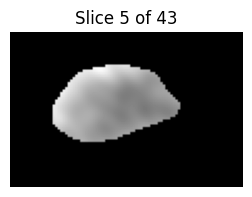

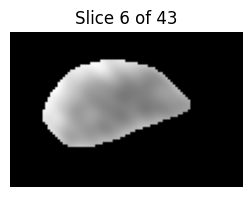

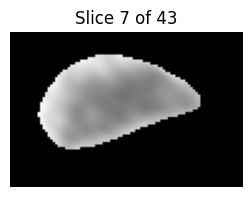

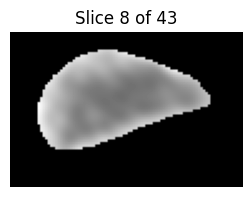

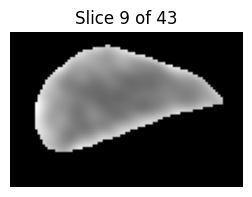

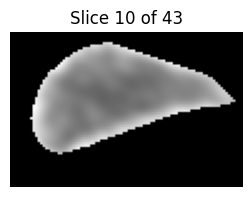

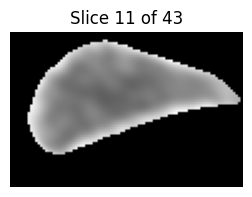

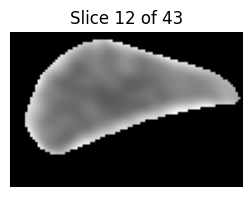

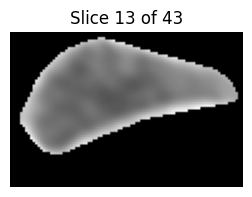

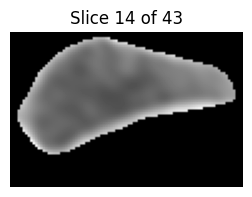

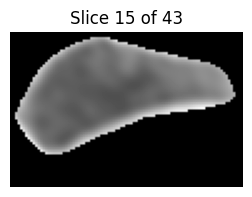

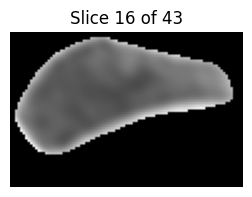

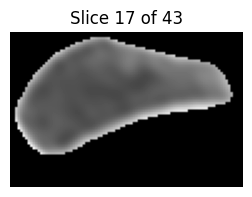

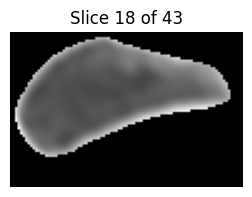

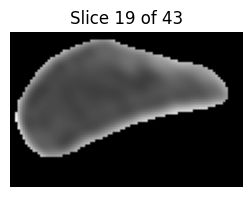

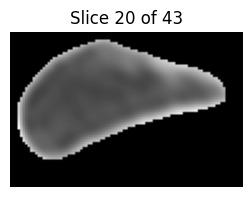

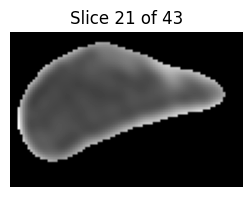

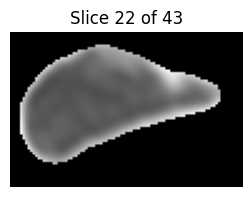

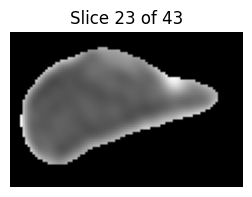

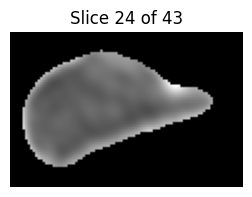

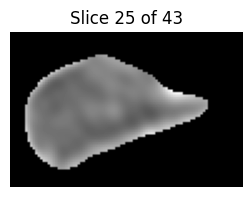

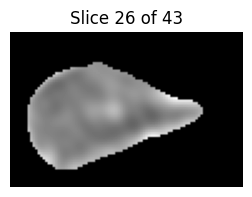

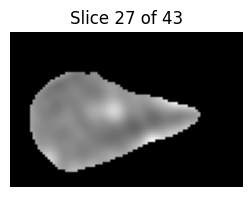

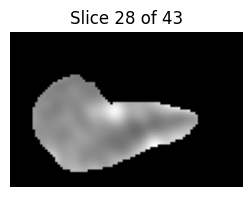

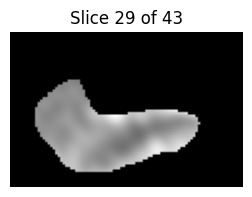

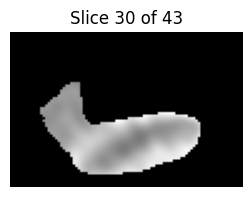

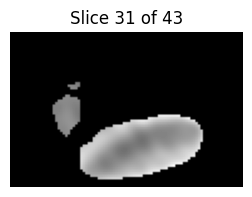

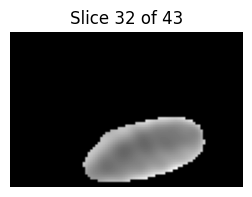

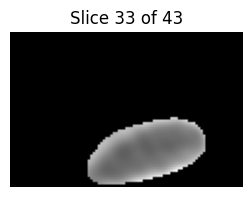

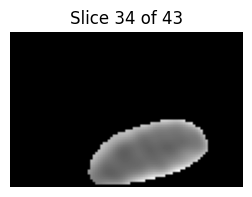

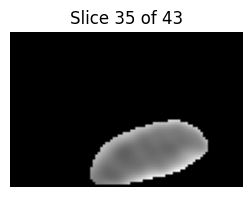

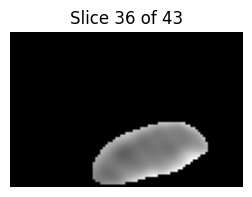

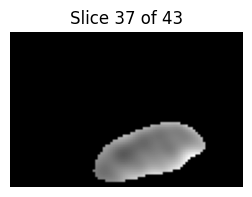

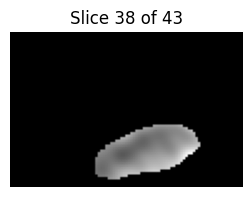

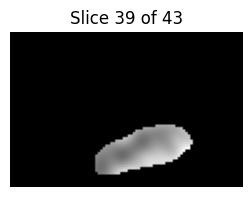

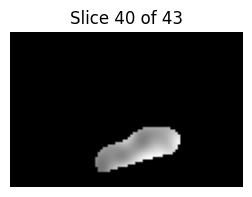

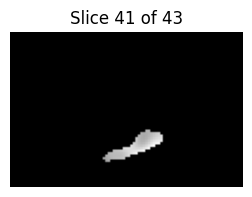

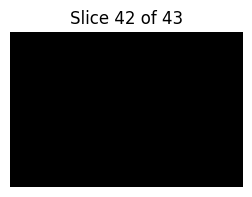

In [56]:
import random

# Function to display a specific slice
def show_slice(z_idx, cropped_image):
    plt.figure(figsize=(3,3))
    plt.imshow(cropped_image[z_idx, :, :], cmap="gray")
    plt.title(f"Slice {z_idx} of {z_max}")
    plt.axis('off')
    plt.show()

# Randomly select a number between 0 and 999
random_number = random.randint(0, 999)
img, cell_type = neuromast_cells[random_number]
metadata = pd.read_csv("/mnt/efs/dlmbl/G-et/data/neuromast/Dataset/metadata.csv")
row = metadata.iloc[random_number]
z_min = row['Z_min']
z_max = row['Z_max']

# Loop through all slices in the Z dimension and display them
for z_idx in range(z_min, z_max-1):
    show_slice(z_idx, img)

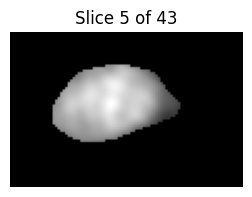

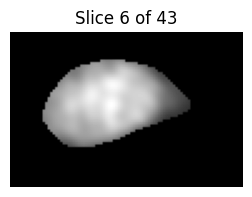

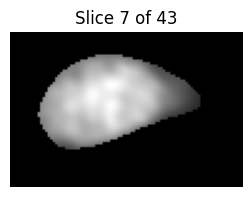

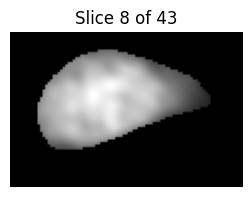

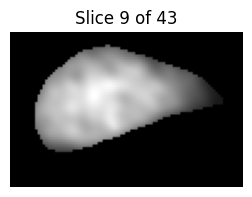

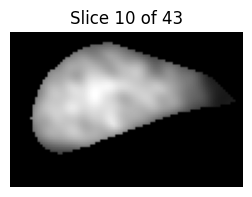

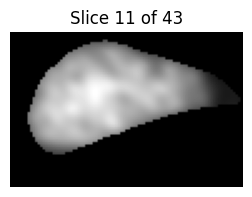

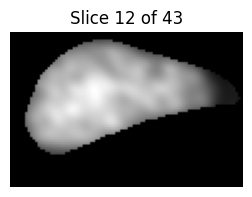

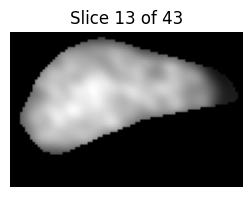

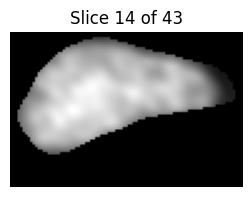

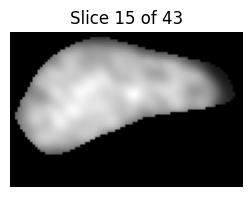

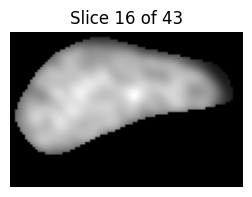

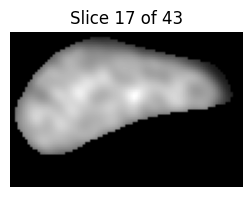

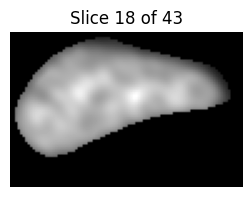

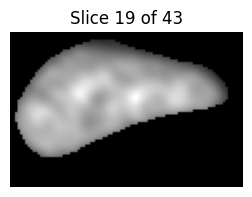

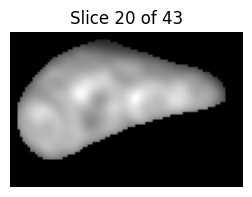

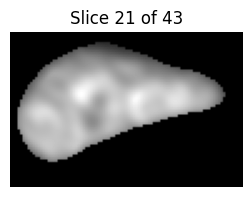

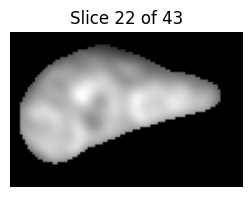

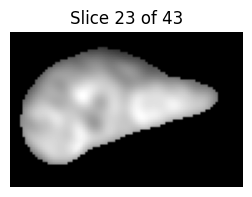

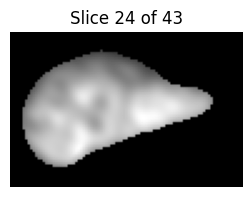

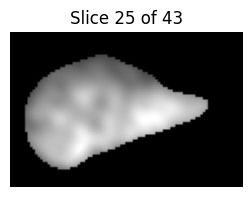

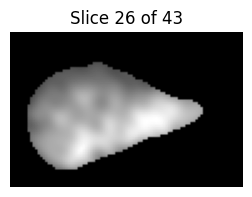

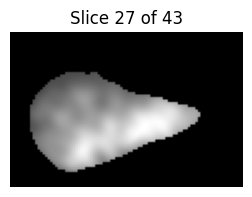

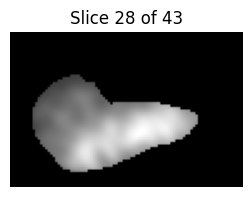

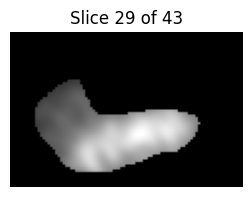

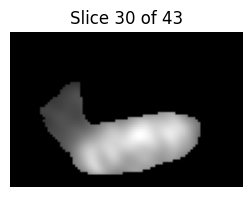

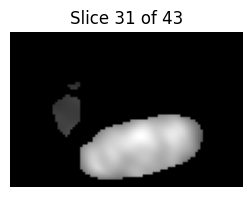

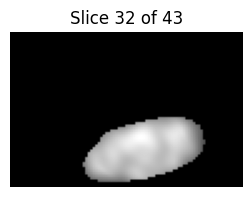

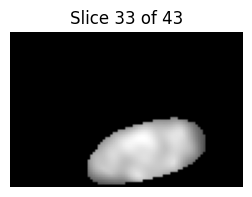

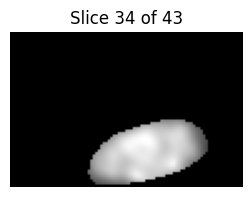

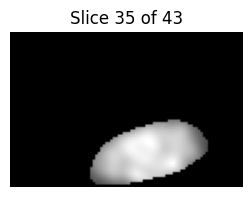

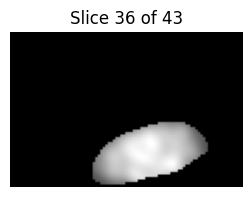

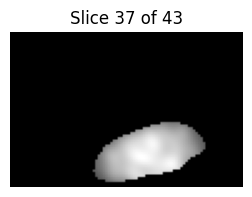

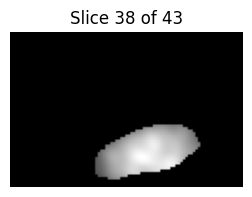

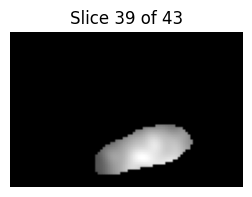

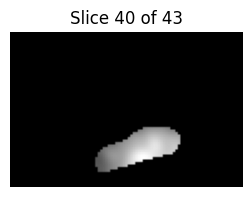

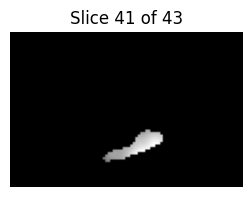

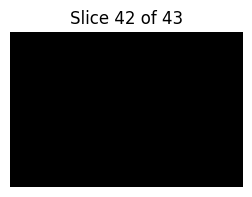

In [57]:
# Determine the number of slices in the Z dimension
num_slices = cropped_image_green.shape[0]

# Function to display a specific slice
def show_slice(z_idx, cropped_image):
    plt.figure(figsize=(3,3))
    plt.imshow(cropped_image[z_idx, :, :], cmap="gray")
    plt.title(f"Slice {z_idx} of {num_slices}")
    plt.axis('off')
    plt.show()
# Loop through all slices in the Z dimension and display them
for z_idx in range(z_min, z_max-1):
    show_slice(z_idx, cropped_image_green)